In [ ]:
!pip install yfinance
!pip install pandas_ta
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

import pickle

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

In [ ]:
# Load silver price
df = yf.Ticker("SI=F")
data = df.history(period="max")
data.drop([column for column in data.columns if column not in ['Open','Close', 'High', 'Low']], axis=1, inplace=True)

In [ ]:
data.head()

,Open,High,Low,Close
Date,,,,
2000-08-30,4.950,4.950,4.895,4.930
2000-08-31,4.920,5.045,4.920,5.003
2000-09-01,5.035,5.035,4.985,5.004
2000-09-05,4.990,5.005,4.975,4.998
2000-09-06,5.000,5.000,4.980,4.983


In [ ]:
chart = yf.Ticker("SI=F").history(period="2y")
fig = go.Figure(data=[go.Candlestick(x=chart.index,
                open=chart['Open'],
                high=chart['High'],
                low=chart['Low'],
                close=chart['Close'])])

fig.show()

In [ ]:
# Add gold price
df = yf.Ticker("GC=F")
gold = df.history(period="max")
data['Gold'] = gold['Close']

In [ ]:
data.isna().sum()

Open     0
High     0
Low      0
Close    0
Gold     3
dtype: int64

In [ ]:
data['Gold'].fillna(method='ffill', inplace=True)

In [ ]:
data.isna().sum()

Open     0
High     0
Low      0
Close    0
Gold     0
dtype: int64

In [ ]:
data.tail()

,Open,High,Low,Close,Gold
Date,,,,,
2022-04-20,25.215000,25.270000,25.215000,25.270000,1952.300049
2022-04-21,25.280001,25.280001,24.621000,24.621000,1944.900024
2022-04-22,24.725000,24.725000,24.215000,24.257000,1931.000000
2022-04-25,23.667999,23.667999,23.667999,23.667999,1893.199951
2022-04-26,23.705000,23.975000,23.594999,23.670000,1899.599976


In [ ]:
# Add Silver and Gold price change 10, 30, 100 days in percentage points
windows = [10, 30, 100]
for window in windows:
    data["Silver_"+str(window)] = data['Close'].rolling(window+1).apply(lambda x: (x.iloc[window] - x.iloc[0]) / x.iloc[0] * 100)
    data["Gold_"+str(window)] = data['Gold'].rolling(window+1).apply(lambda x: (x.iloc[window] - x.iloc[0]) / x.iloc[0] * 100)

In [ ]:
data.tail()

,Open,High,Low,Close,Gold,Silver_10,Gold_10,Silver_30,Gold_30,Silver_100,Gold_100
Date,,,,,,,,,,,
2022-04-20,25.215000,25.270000,25.215000,25.270000,1952.300049,3.025117,1.528942,-6.017554,-4.303707,7.550222,9.427727
2022-04-21,25.280001,25.280001,24.621000,24.621000,1944.900024,0.678799,1.381359,-4.410450,-2.064555,6.552127,8.939672
2022-04-22,24.725000,24.725000,24.215000,24.257000,1931.000000,-1.924554,-0.144795,-7.423096,-3.358189,6.395018,8.343149
2022-04-25,23.667999,23.667999,23.667999,23.667999,1893.199951,-4.637580,-2.492791,-9.338855,-4.514047,3.966615,6.743346
2022-04-26,23.705000,23.975000,23.594999,23.670000,1899.599976,-5.236610,-2.299032,-6.235143,-3.061849,6.148259,6.623260


In [ ]:
# Add technical indicators RSI, MACD and Stochastic Oscillator for Silver
data['RSI_14']=ta.rsi(data['Close'],lenght=14)

MACD = ta.macd(data['Close'],fast=12, slow=26, signal=9)
data = pd.concat([data,MACD],axis=1)

STOCH = ta.stoch(high=data.High,low=data.Low,close=data.Close)
data = pd.concat([data, STOCH], axis=1)

In [ ]:
data.tail()

,Open,High,Low,Close,Gold,Silver_10,Gold_10,Silver_30,Gold_30,Silver_100,Gold_100,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,STOCHk_14_3_3,STOCHd_14_3_3
Date,,,,,,,,,,,,,,,,,
2022-04-20,25.215000,25.270000,25.215000,25.270000,1952.300049,3.025117,1.528942,-6.017554,-4.303707,7.550222,9.427727,51.028816,0.176698,0.039743,0.136955,70.018551,81.145463
2022-04-21,25.280001,25.280001,24.621000,24.621000,1944.900024,0.678799,1.381359,-4.410450,-2.064555,6.552127,8.939672,44.782169,0.104334,-0.026097,0.130431,41.888926,63.909431
2022-04-22,24.725000,24.725000,24.215000,24.257000,1931.000000,-1.924554,-0.144795,-7.423096,-3.358189,6.395018,8.343149,41.698991,0.017412,-0.090416,0.107827,23.153213,45.020230
2022-04-25,23.667999,23.667999,23.667999,23.667999,1893.199951,-4.637580,-2.492791,-9.338855,-4.514047,3.966615,6.743346,37.232059,-0.097874,-0.164561,0.066687,5.930978,23.657706
2022-04-26,23.705000,23.975000,23.594999,23.670000,1899.599976,-5.236610,-2.299032,-6.235143,-3.061849,6.148259,6.623260,37.256647,-0.186923,-0.202888,0.015965,1.709598,10.264597


In [ ]:
# Prepare the target - Silver price direction change over next window days
window = 10
data['Target'] = data['Close'].rolling(window + 1).apply(lambda x: x.iloc[window] > x.iloc[0]) 

In [ ]:
# We want to know the future outcome pre-fact to train our model
data['Target'] = data['Target'].shift(-window)

In [ ]:
data.shape

(5434, 18)

In [ ]:
data.isna().sum()

Open               0
High               0
Low                0
Close              0
Gold               0
Silver_10         10
Gold_10           10
Silver_30         30
Gold_30           30
Silver_100       100
Gold_100         100
RSI_14            14
MACD_12_26_9      25
MACDh_12_26_9     33
MACDs_12_26_9     33
STOCHk_14_3_3     15
STOCHd_14_3_3     17
Target            10
dtype: int64

In [ ]:
# Remove first 100 rows (missing values for technical indicators) and last 10 rows (missing Target)
data.dropna(axis=0, inplace=True)
data.isna().sum().sum()

0

In [ ]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Gold', 'Silver_10', 'Gold_10',
       'Silver_30', 'Gold_30', 'Silver_100', 'Gold_100', 'RSI_14',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'STOCHk_14_3_3',
       'STOCHd_14_3_3', 'Target'],
      dtype='object')

In [ ]:
# We can remove first 5 columns, as we are not interested in present nominal values
data.drop(['Open','High','Low','Close','Gold'], axis=1, inplace=True)

In [ ]:
# Saving copy of clean data
data.to_csv('data.csv')
data_to_backtest = data

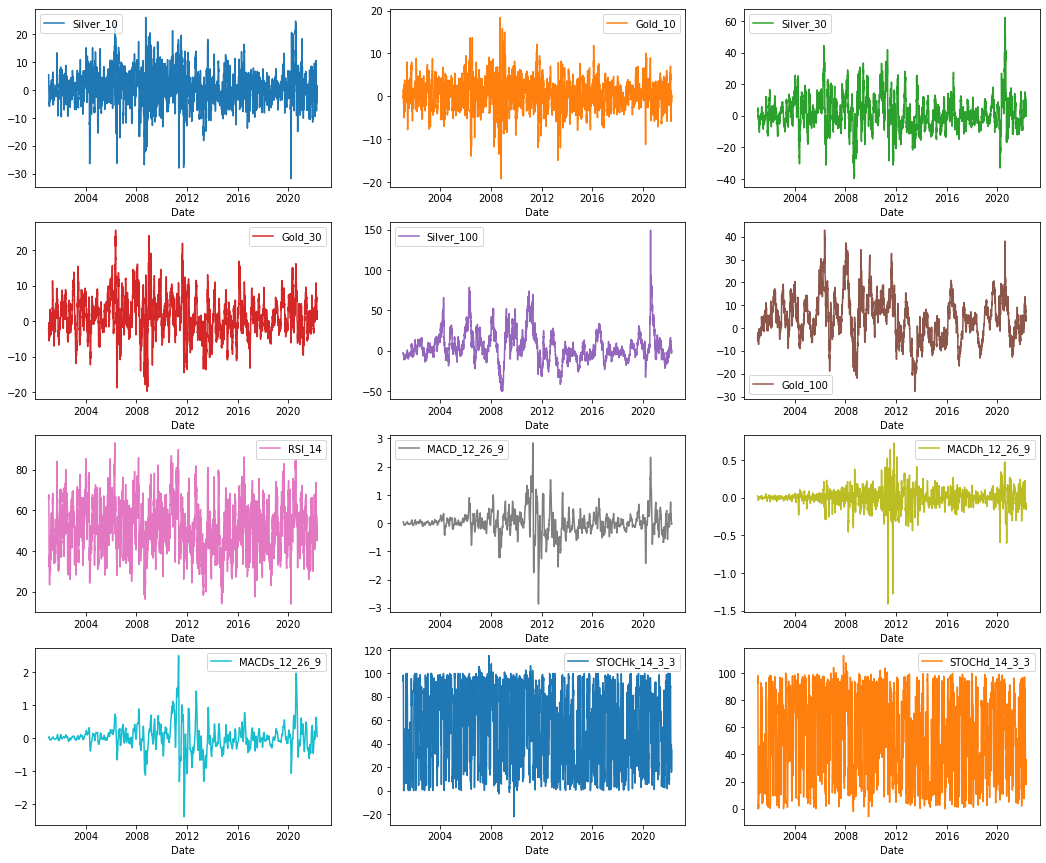

In [ ]:
features = data[[column for column in data.columns if column !='Target']]
features.plot(subplots=True, sharex=False, layout=(4,3), figsize=(18,15))
plt.show()

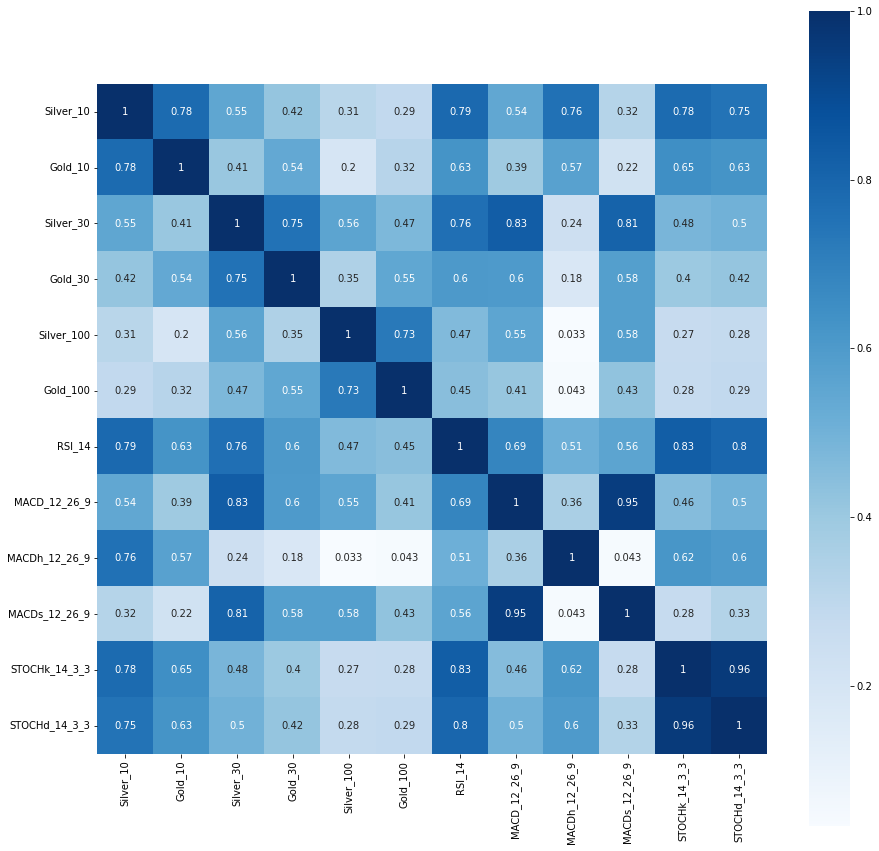

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(features.corr(),square=True,cmap="Blues",annot=True)
plt.show()

In [ ]:
target = data['Target']

In [ ]:
target.value_counts()

1.0    2872
0.0    2452
Name: Target, dtype: int64

In [ ]:
target.value_counts(normalize=True)

1.0    0.539444
0.0    0.460556
Name: Target, dtype: float64

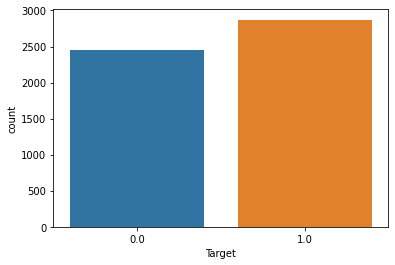

In [ ]:
ax = sns.countplot(target)
plt.show()

54% of the ten-day periods were up for silver. 54% of the ten-day periods were up for silver. This means that a naive algorithm that always forecasts price increases would have 54% accuracy. We will try to beat this result.

For model selection, we will select the most promising models taking into account our previous projects and financial literature.


In [ ]:
models = []
models.append(('RF', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('GRAD', GradientBoostingClassifier()))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=9)

In [ ]:
results = []
names = []
for name, model in models:
    results.append(cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy'))
    names.append(name)

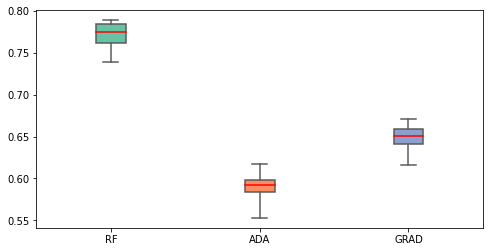

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(ax=ax, data=results, orient='v',  palette="Set2", saturation=1, width=0.2, whis=5, medianprops=dict(color="red", alpha=1))
ax.set_xticklabels(names)
plt.show()

In [ ]:
n_estimators = range(10,150,10)
params = {
    'n_estimators': n_estimators,
    }

In [ ]:
grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, scoring='accuracy', cv=10)

In [ ]:
results = grid.fit(X_train, y_train)

In [ ]:
print(results.best_params_)
print(results.best_score_)

{'n_estimators': 110}
0.7715388014360673


0.708850 (0.016663) with: {'n_estimators': 10}
0.737259 (0.016327) with: {'n_estimators': 20}
0.748294 (0.011518) with: {'n_estimators': 30}
0.753929 (0.016919) with: {'n_estimators': 40}
0.760972 (0.019786) with: {'n_estimators': 50}
0.760272 (0.015728) with: {'n_estimators': 60}
0.758618 (0.020979) with: {'n_estimators': 70}
0.766607 (0.013583) with: {'n_estimators': 80}
0.760737 (0.012133) with: {'n_estimators': 90}
0.766376 (0.010840) with: {'n_estimators': 100}
0.771539 (0.011342) with: {'n_estimators': 110}
0.763553 (0.011833) with: {'n_estimators': 120}
0.770133 (0.013757) with: {'n_estimators': 130}
0.771070 (0.009068) with: {'n_estimators': 140}


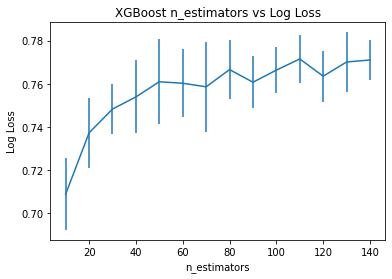

In [ ]:
means = results.cv_results_['mean_test_score']
stds = results.cv_results_['std_test_score']
params = results.cv_results_['params']
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("Accuracy of Random Forest algoritm")
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

It seems that without changing other parameters, we achieve the highest accuracy of 0.77 with n_estimators = 110. Let's try to optimize the remaining parameters.

In [ ]:
params = {
     'n_estimators': [110],
     'bootstrap': [True, False],
     'max_features': ['auto', 'sqrt'],
     'min_samples_split' : [2, 4],
     'min_samples_leaf' : [1, 2],
     'criterion' : ["gini","entropy"]
     }

In [ ]:
grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, scoring='accuracy', cv=10)
# Computing time ~ 16 mins
results = grid.fit(X_train, y_train)
print(results.best_params_)
print(results.best_score_)

{'bootstrap': False, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 110}
0.7821082573874619


In [ ]:
model = RandomForestClassifier(criterion='gini', bootstrap=False, max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=110)


In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, n_estimators=110)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# What is an accuracy on the train sample?
accuracy_score(y_test, y_pred)

0.7774647887323943

In [ ]:
pickle.dump(model, open('model.sav', 'wb'))

# Backtesting

In [ ]:
model = pickle.load(open('model.sav', 'rb'))

In [ ]:
silver_price = yf.Ticker("SI=F").history(period='max')['Close']

In [ ]:
type(silver_price)

pandas.core.series.Series

In [ ]:
data = pd.concat((data_to_backtest, silver_price), axis=1, join='inner')

In [ ]:
data.tail()

,Silver_10,Gold_10,Silver_30,Gold_30,Silver_100,Gold_100,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,STOCHk_14_3_3,STOCHd_14_3_3,Target,Close
Date,,,,,,,,,,,,,,
2022-04-05,-1.434601,0.114545,0.892596,0.881383,-0.964995,4.075560,45.765999,0.012309,-0.157632,0.169940,19.278785,29.691669,1.0,24.528000
2022-04-06,-2.840684,-0.939789,-0.407251,0.481881,-3.343744,2.962649,45.080108,-0.028794,-0.158988,0.130193,15.633557,21.916861,1.0,24.455000
2022-04-07,-4.505791,-1.417207,0.190387,0.451928,-2.410827,3.528027,48.260228,-0.038492,-0.134949,0.096456,18.538042,17.816795,0.0,24.733000
2022-04-08,-3.031839,-0.624428,3.425430,2.920751,-1.147091,4.045871,49.239449,-0.038792,-0.108198,0.069407,24.210561,19.460720,0.0,24.819000
2022-04-11,-0.786463,0.242322,2.532739,2.363906,0.136307,4.893185,51.082768,-0.025900,-0.076245,0.050345,34.405501,25.718035,0.0,24.978001


In [ ]:
# Buy and hold return on dataset
(data['Close'][-1] - data['Close'][0]) / data['Close'][0]

4.2200629963192355

In [ ]:
years_delta = (data.index[-1] - data.index[0]).days / 365.2425
years_delta

21.20782767613298

In [ ]:
CAGR_bah = ((data['Close'][-1] / data['Close'][0]) ** (1/years_delta) - 1)
CAGR_bah

0.0810359448508351

In [ ]:
data['Prediction'] = model.predict(data.drop(['Target', 'Close'],axis=1))


ValueError: ignored

In [ ]:
series=data['Prediction']==data['Target']
series.value_counts()

True     5087
False     237
dtype: int64

In [ ]:
data.head()

,Silver_10,Gold_10,Silver_30,Gold_30,Silver_100,Gold_100,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,STOCHk_14_3_3,STOCHd_14_3_3,Target,Close,Prediction
Date,,,,,,,,,,,,,,,
2001-01-25,5.512679,-0.075562,2.770612,-2.109553,-2.941176,-3.431907,65.966105,0.042484,0.024565,0.017919,93.607071,92.352226,0.0,4.785,0.0
2001-01-26,5.442169,-0.454550,3.111588,-2.774695,-3.957625,-5.569530,67.738888,0.046738,0.023055,0.023683,95.580766,93.912777,0.0,4.805,0.0
2001-01-29,3.916048,-0.416827,3.893572,-2.159352,-4.016791,-5.126358,67.361049,0.049378,0.020557,0.028822,98.621191,95.936343,0.0,4.803,0.0
2001-01-30,2.544365,0.835553,4.306219,-1.301115,-4.041619,-3.734586,65.973901,0.050326,0.017203,0.033123,98.646503,97.616154,0.0,4.796,0.0
2001-01-31,1.719742,0.911852,4.996706,-1.775143,-3.853099,-3.136399,64.945106,0.050096,0.013579,0.036517,96.764789,98.010828,0.0,4.791,0.0
